# Neural Network from Scratch

This notebook creates neural network algorithms using only the linear algebra library `numpy` . The sample data is a 2-dimensional data with three classes in a form of spirals. 

The content consists of the following aspects of neural networks:

* Weight initialization
* Loss functions
    * Cross-entropy loss
    * Hinge loss
    * Regularization loss
* Layers
    * Linear
    * Sigmoid
    * Tanh
    * ReLu
    * Swish
    * Softmax
    * Hierarchical Softmax (TBD)
    * SVM
    * Dropout
    * Batch Normalization
    * Convolution (TBD)
    * Pooling (TBD)
    * RNN (TBD)
    * LSTM (TBD)
    * Embeddings (TBD)
    * Capsule (TBD)
* Training
    * Linear > Softmax
    * Linear > SVM
    * [Linear > Activation]++ > [Linear > Output]
* Optimization
    * Gradient Descent (GD/SGD/Mini-batch SGD) (TBD)
    * RMS Prop (TBD)
    * Momentum (TBD)
    * Adam (TBD)
* Validation

In [11]:
%matplotlib inline

#usual data science stuff
import matplotlib
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import itertools

In [ ]:
# DATA GENRATION

In [96]:
def spi_gen(N,D,K):

    X = np.zeros((N*K,D)) # data matrix 
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    return(X,y)

In [98]:
D = 2 #2 features
K = 3 #3 classes
N = 3000 #number of samples

X,y = spi_gen(int(N/K),D,K)
print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

Shape of X: (30000, 2)
Shape of y: (30000,)


# Weight Initialization

We usually initialize the bias terms $b_i$ as zero vectors, and the weight terms $W_i$ as randomized matrices with different scaling terms.

* Constant scaling
* Xavier scaling: $\sqrt{\frac{1}{nodes_{previous}}}$
* He scaling: $\sqrt{\frac{2}{nodes_{previous}}}$

In [99]:
def init_weights(D,K,h_list,scaling,const=0.1):
    nb_layers = len(h_list) + 1
    W_list = [None] * nb_layers
    b_list = [None] * nb_layers
    
    #randomize weights
    for i in range(nb_layers):
        #scaling term
        if scaling=='constant':
            scaler = const
        elif scaling=='xavier':
            scaler = np.sqrt(1.0 / h_list[i - 1])
        elif scaling=='he':
            scaler = np.sqrt(2.0 / h_list[i - 1])
        else:
            raise ValueError('Can only use "constant","xavier" or "he" scaling')
            
        #input layer
        if (i == 0):
            W_list[i] = np.random.randn(D,h_list[i])
            b_list[i] = np.zeros((1,h_list[i]))
        #output layer
        elif (i==nb_layers-1):
            W_list[i] = np.random.randn(h_list[i-1],K) * scaler
            b_list[i] = np.zeros((1,K))
        #hidden layers
        else:
            W_list[i] = np.random.randn(h_list[i-1],h_list[i]) * scaler
            b_list[i] = np.zeros((1,h_list[i]))
    return W_list, b_list

W_list, b_list = init_weights(2,3,[100,50],'he')
W, b = W_list[0], b_list[0]

# Loss Functions

Loss functions are objective functions to be minimized during the training.

## Cross-Entropy Loss

For each example, the loss is the negative log of predicted probability of the correct class
$$L_i = -\sum_{k=1}^{K} y_klog(p_k)$$
where 
* $y_k$ is the true probability of the class; in 1 or 0
* $p_k$ is probability of a class
* $i$ is an example

The higher probability of the correct class, the lower the loss (for incorrect classes $y_k = 0$ so loss is 0)

done


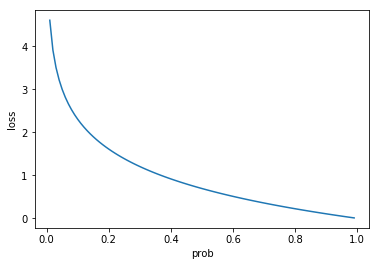

In [59]:
p = np.arange(0.01, 1, 0.01)
plt.plot(p,-np.log(p))
plt.xlabel('prob')
plt.ylabel('loss')
print("done")

In [60]:
def cross_entropy(probs,y):
    #probs: N x K
    N = probs.shape[0]
    #print('All normalized probs:',probs.shape)
    
    #normalized prob of correct label
    correct_logprobs = -np.log(probs[range(N),y])
    #print('-log(normalized probs) when label is correct:',correct_logprobs.shape)
    
    #data loss
    data_loss = np.sum(correct_logprobs) / N
    
    return(data_loss)

#test
probs = np.random.random((3000,3))
print('Cross entropy loss: {}'.format(cross_entropy(probs,y)))

Cross entropy loss: 0.9988723855347921


## Hinge Loss

For an example, the loss per class per example is positive only when the score of wrong class is more than score of correct class by margin.

$$L_{i} = \sum_{other \ne correct}^{K} max(0,scores_{other} - scores_{correct} + \Delta)$$

Loss is positive only when the score of correct class is lower than an incorrect class, by magnitude more than margin.

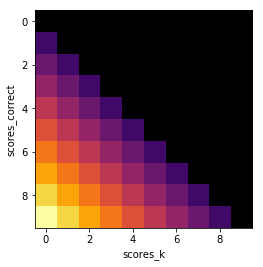

In [100]:
p = np.random.random((10, 10))
delta=1
for i in range(0,p.shape[0]):
    fk=i+1
    for j in range(0,p.shape[1]):
        fcorrect=j+1
        if i==j:
            p[i,j]=0
        else:
            p[i,j] = max(0,fk-fcorrect+delta)

plt.imshow(p, cmap='inferno', interpolation='nearest')
plt.xlabel('scores_k')
plt.ylabel('scores_correct')
plt.show()

In [62]:
def hinge(scores,y):
    #scores: N x K
    N = probs.shape[0]
    
    correct_scores = scores[range(N),y]
   
    # need to broadcast by row not columns
    margin = scores.T - correct_scores + delta 
    margin = margin.T
    
    #zero loss at the correct label
    margin[range(N),y] = 0 
    
    #element-wise max
    margin = np.maximum(np.zeros(margin.shape),margin) 
    data_loss = np.sum(margin) / N

    
    return(data_loss)

#test
scores = np.random.random((3000,3))
print('Hinge loss: {}'.format(hinge(scores,y)))

Hinge loss: 1.9885116975076162


## Regularization

Regularization loss is usually added to the loss function in order to prevent overfitting. It penalizes more complex weight terms.

Data loss:

$$L_{data} = \frac{1}{N}\sum_{n=1}^{N}L_i$$

Regularization loss:

$$l1 = \frac{\lambda}{2}|W|$$
$$l2 = \frac{\lambda}{2}W^2$$

where $W$ is the weights

Overall loss:
$$L_{overall} = L_{data} + L_{reg}$$

In [63]:
def reg_loss_calc(W_list, l2=True, reg=1e-3):
    loss = 0
    if(l2):
        for i in range(len(W_list)):
            loss += 0.5 * reg * np.sum(W_list[i]* W_list[i])
    else:
        for i in range(len(W_list)):
            loss += 0.5 * reg * np.sum(abs(W_list[i]))
    return(loss)

#test
W_list = []
for i in range(4):
    W_list.append(np.random.randn(D,K))

print('L2 Loss: {}'.format(reg_loss_calc(W_list,l2=True)))
print('L1 Loss: {}'.format(reg_loss_calc(W_list,l2=False)))

L2 Loss: 0.010377472091420606
L1 Loss: 0.009064619175653892


# Layers

Layers are roughly classified into linear, activation and output layers. The output of their function is what passed to the next layer in the forward pass of training and the derivative is what passed to the previous layer in the backward pass.

## Linear

### Forward Pass

$$scores = X \cdot W + b$$

### Backward Pass

$$\frac{\partial previous}{\partial W} = \frac{\partial previous}{\partial scores} \cdot \frac{\partial scores}{\partial W} = \frac{\partial previous}{\partial scores} \cdot X$$

$$\frac{\partial previous}{\partial b} = \frac{\partial previous}{\partial scores} \cdot \frac{\partial scores}{\partial b} = \frac{\partial previous}{\partial scores} \cdot 1$$

Text(0,0.5,'out')

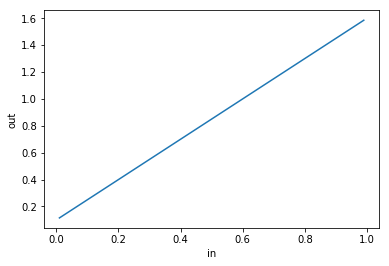

In [19]:
x = np.arange(0.01, 1, 0.01)
w = 1.5
b = 0.1
plt.plot(x,w*x + b)
plt.xlabel('in')
plt.ylabel('out')

In [64]:
class Linear:
    def forward(self,X,W,b):
        #X: N x D
        #W: D x K
        scores = X.dot(W) + b #N x K
        return(scores)
    def backward(self,X,W,previous,reg=1e-3):
        #previous: N x K
        dW = X.T.dot(previous)
        dW += reg * W
        db = np.sum(previous,axis=0,keepdims=True)
        return dW,db

#test
lin = Linear()
scores = lin.forward(X,W,b)
previous = np.ones_like(scores)
dW, db = lin.backward(X,W,previous)
print('Forward pass: {}'.format(scores.shape))
print('Backward pass: {}, {}'.format(dW.shape,db.shape))

Forward pass: (3000, 100)
Backward pass: (2, 100), (1, 100)


## Sigmoid

### Forward Pass

$$out = \frac{1}{1 + e^{-scores}}$$

### Backward Pass

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial scores}
\\
\frac{\partial out}{\partial scores} = (-1) \cdot (\frac{1}{1+e^{-x}})^2 \cdot (-1) \cdot (\frac{1}{e^x})^2 \cdot e^x 
\\
= \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}} \cdot \frac{e^{-x}}{1+e^{-x}} = out \cdot \frac{e^{-x}}{1+e^{-x}} \\
= out \cdot \frac{(1+e^{-x}) - 1}{1+e^{-x}} = out \cdot (1 - out)$$

Text(0,0.5,'out')

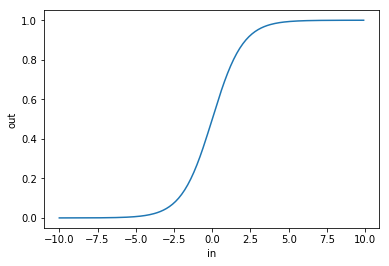

In [65]:
scores_p = np.arange(-10, 10, 0.1)
out_p = 1. / (1. + np.exp(-scores_p))
plt.plot(scores_p, out_p)
plt.xlabel('in')
plt.ylabel('out')

In [66]:
class Sigmoid:

    def forward(self,scores):
        #scores: N x K
        out = 1.0 / (1.0 + np.exp(-scores))
        return out
    
    def backward(self,scores,previous):
        out = self.forward(scores)
        dscores = (1.0 - out) * out * previous
        return(dscores)
#test
sig = Sigmoid()
out = sig.forward(scores)
dscores = sig.backward(scores,previous)
print('Forward pass: {}'.format(out.shape))
print('Backward pass: {}'.format(dscores.shape))

Forward pass: (3000, 100)
Backward pass: (3000, 100)


## Tanh

### Forward Pass

$$out = \tanh(scores)$$

### Backward Pass

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial scores}
\\
\frac{\partial out}{\partial scores} = 1 - \tanh^2(scores) = 1 - out^2$$

Text(0,0.5,'out')

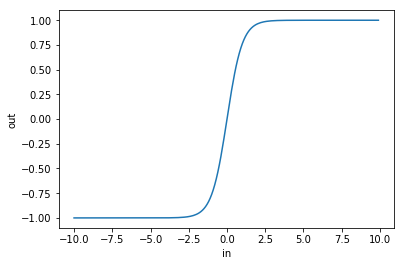

In [23]:
scores_p = np.arange(-10, 10, 0.1)
out_p = np.tanh(scores_p)
plt.plot(scores_p, out_p)
plt.xlabel('in')
plt.ylabel('out')

In [67]:
class Tanh:
    def forward(self,scores):
        #scores: N x K
        out = np.tanh(scores)
        return out
    
    def backward(self,scores,previous):
        out = self.forward(scores)
        dscores = (1.0 - np.square(out)) * previous
        return(dscores)
#test
tanh = Tanh()
out = tanh.forward(scores)
dscores = tanh.backward(scores,previous)
print('Forward pass: {}'.format(out.shape))
print('Backward pass: {}'.format(dscores.shape))

Forward pass: (3000, 100)
Backward pass: (3000, 100)


## ReLu

### Forward Pass

$$out = max(0,scores)$$

### Backward Pass

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial scores}
\\
\frac{\partial out}{\partial scores} = 
\begin{cases}
1 & scores > 0 \\
0 & otherwise
\end{cases}$$

Text(0,0.5,'out')

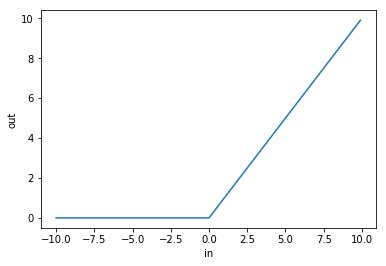

In [68]:
scores_p = np.arange(-10, 10, 0.1)
out_p = np.maximum(0,scores_p)
plt.plot(scores_p, out_p)
plt.xlabel('in')
plt.ylabel('out')

In [69]:
class ReLu:
    def forward(self,scores):
        #scores: N x K
        out = scores * (scores > 0)
        return out
    def backward(self, scores, previous):
        dscores = 1.0 * (scores > 0) * previous
        return(dscores)

#test
relu = ReLu()
out = relu.forward(scores)
dscores = relu.backward(scores,previous)
print('Forward pass: {}'.format(out.shape))
print('Backward pass: {}'.format(dscores.shape))

Forward pass: (3000, 100)
Backward pass: (3000, 100)


## Swish

### Forward Pass

$$out = scores \cdot \frac{1}{1 + e^{-scores}}$$

### Backward Pass

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial scores}
\\
\frac{\partial out}{\partial scores} =scores \cdot \frac{\partial \sigma(scores)}{\partial scores} + \sigma(scores) \cdot 1\\
= scores  \cdot \sigma(scores) \cdot (1-\sigma(scores)) + \sigma(scores) \\
= scores \cdot \sigma(scores) - scores \cdot (\sigma(scores))^2 + \sigma(scores) \\
= out + \sigma(scores) \cdot (1-out)
$$

Text(0,0.5,'out')

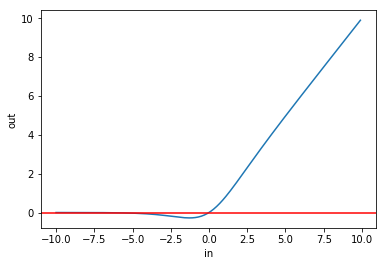

In [70]:
scores_p = np.arange(-10, 10, 0.1)
out_p = scores_p / (1. + np.exp(-scores_p))
plt.plot(scores_p, out_p)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('in')
plt.ylabel('out')

In [71]:
class Swish:
    def sigmoid(self,scores):
        out = 1.0 / (1.0 + np.exp(-scores))
        return out

    def forward(self,scores):
        #scores: N x K
        out = scores / (1.0 + np.exp(-scores))
        return out
    
    def backward(self,scores,previous):
        out = self.forward(scores)
        dscores = (out + self.sigmoid(scores) * (1-out)) * previous
        return(dscores)
#test
sw = Swish()
out = sw.forward(scores)
dscores = sw.backward(scores,previous)
print('Forward pass: {}'.format(out.shape))
print('Backward pass: {}'.format(dscores.shape))

Forward pass: (3000, 100)
Backward pass: (3000, 100)


## Dropout

Randomly chose nodes of previous layer to be *turned off*. The scaler $\frac{1}{1-p}$ is added to keep the expectation of activation output the same as when there is no Dropout.

$$mask = 
\begin{cases}
\frac{1}{1-p} & u >= p\\
0 & u < p
\end{cases}$$

where $u$ is a sample from uniform distribution of $[0,1]$ and $p$ is the threshold for percentage of nodes to be dropped.

### Forward Pass


$$out = mask \cdot scores$$

### Backward Pass

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial scores}
\\
\frac{\partial out}{\partial scores} = mask$$

In [72]:
class Dropout:
    def __init__(self,p,seed):
        self.seed = seed
        self.p = p
    def mask(self,scores,scaling=True):
        #if no dropout
        if self.p == 1: return np.ones_like(scores)
        
        np.random.seed(seed=self.seed)
        if (scaling): 
            scaler = 1.0/(1-self.p)
        else:
            scaler = 1.0
        mask = scaler * np.random.binomial(n=1,p=self.p,size=scores.shape)
        return(mask)
    
#test
drop = Dropout(p=0.7,seed = 1412)
mask = drop.mask(scores)
print('Forward pass: {}'.format(mask.shape))
print('Backward pass: {}'.format(mask.shape))
mask

Forward pass: (3000, 100)
Backward pass: (3000, 100)


array([[0.        , 0.        , 3.33333333, ..., 3.33333333, 3.33333333,
        3.33333333],
       [3.33333333, 3.33333333, 3.33333333, ..., 3.33333333, 3.33333333,
        3.33333333],
       [3.33333333, 3.33333333, 0.        , ..., 3.33333333, 0.        ,
        0.        ],
       ...,
       [3.33333333, 0.        , 3.33333333, ..., 0.        , 3.33333333,
        3.33333333],
       [3.33333333, 3.33333333, 0.        , ..., 0.        , 0.        ,
        3.33333333],
       [3.33333333, 3.33333333, 3.33333333, ..., 3.33333333, 3.33333333,
        3.33333333]])

## Batch Normalization

Batch Normalization layer converts the activation to a gaussian distribution, then feed it to another linear layer (Norm > Linear). The process is redone every iteration, thus *batch* normalization. The benefits of using Linear > BatchNorm (Norm > Linear) > Activation > Dropout are:

* Faster gradient flow
* Allows higher learning rates
* Reduce dependence on initialization
* Regularization

### Forward
$$normalized_{i,j} = \frac{scores_{i,j} - \mu_j}{\sqrt{{\sigma_j}^2 + \epsilon}}$$

where $i$ is row of examples, $j$ is column of features and $\epsilon$ is a small sclaer for numerical stability and regularization.

$$out = c  + normalized \cdot D$$

where $c$ and $D$ are learned parameters in order to adjust *how normalized* the output needs to be.

### Backward Pass

#### Scores

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial normalized} \cdot \frac{\partial normalized}{\partial scores}
\\
\frac{\partial out}{\partial normalized} = D\\
\frac{\partial normalized}{\partial scores} = \frac{\sqrt{{\sigma_j}^2 + \epsilon}(1-\frac{\partial \mu_j}{scores_{i,j}}) - (scores_{i,j} - \mu_j)(\frac{1}{2})(\frac{1}{\sqrt{{\sigma_j}^2 + \epsilon}})(2){\sigma_j}^2(\frac{\partial {\sigma_j}^2}{\partial scores_{i,j}})}{{\sigma_j}^2 + \epsilon}\\
\frac{\partial \mu_j}{\partial scores_{i,j}} = \frac{1}{N}\frac{\partial \sum_{k=1}^{K} scores_{k,j}}{\partial scores_{i,j}} = \frac{1}{N}\\
\frac{\partial {\sigma_j}^2}{\partial scores_{i,j}} = \frac{1}{N}\frac{\partial \sum_{k=1}^{K} (scores_{k,j} - \mu_j)^2}{\partial scores_{i,j}} = \frac{2}{N}(scores_{i,j} - \mu_j)(1-\frac{1}{N}) \\
\frac{\partial normalized}{\partial scores} = (1-\frac{1}{N})(\sqrt{{\sigma_j}^2 + \epsilon} - \frac{2\sigma_j(scores_{i,j}-\mu_j)^2}{N\sqrt{{\sigma_j}^2 + \epsilon}})
$$

where N is the number of samples in the batch

#### Linear parameters

$$
\frac{\partial previous}{\partial param} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial param}\\
\frac{\partial out}{\partial c} = 1\\
\frac{\partial out}{\partial D} = normalized\\
$$

In [73]:
class Norm:
    def forward(self,scores,epsilon = 1e-3):
        self.mu = np.mean(scores,axis=0)
        self.sd = np.sqrt(np.var(scores+epsilon,axis=0))
        self.N = scores.shape[0]
        normalized = (scores - self.mu) / self.sd
        return(normalized)
    def backward(self,scores,previous,epsilon = 1e-3):
        out = self.forward(scores,epsilon)
        dnormalized = (1-(1.0/N)) * (self.sd - (2 * np.sqrt(np.var(scores,axis=0)) * (scores - self.mu)**2 )/(self.N * self.sd))
        dnormalized *= previous
        return(dnormalized)

In [74]:
norm = Norm()
print('Variance of output',np.var(norm.forward(X),axis=0))
print('Shape of dnormalized: ',norm.backward(scores,previous).shape)

Variance of output [1. 1.]
Shape of dnormalized:  (3000, 100)


## Softmax

Assume cross-entropy loss.

### Loss

For each example, the loss is the negative log of predicted probability of the correct class
$$L_i = -\sum_{k=1}^{K} y_klog(p_k)$$

### Forward Pass

$$p_{class} = \frac{e^{scores_{class}}}{\sum_{k=1}^{K} e^{scores_{k}}}$$


### Backward Pass

$$\frac{\partial L}{\partial scores_{class}} = \frac{\partial L}{\partial p_{class}} \cdot \frac{\partial p_{class}}{\partial scores_{class}} = - \frac{1}{p_{class}} \cdot \frac{\partial p_{class}}{\partial scores_{class}}
\\
\frac{\partial p_{class}}{\partial scores_{class}} = \frac{\sum_{k=1}^{K} e^{scores_{k}}e^{scores_{class}} - e^{2scores_{class}}}{(\sum_{k=1}^{K} e^{scores_{k}})^2} = p_{class} - p_{class}^2 = 
p_{class}(1-p_{class})\\
\frac{\partial L}{\partial scores_{class}} = p_{class} - 1 * y_{class}$$

In [75]:
class Softmax:
    def forward(self,scores):
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return(probs)
    
    def backward(self,scores,y):
        N = scores.shape[0]
        dscores = self.forward(scores)
        dscores[range(N), y] -= 1
        dscores /= N
        return(dscores)   
    
    def cross_entropy(self,probs,y):
        #probs: N x K
        N = probs.shape[0]
        #print('All normalized probs:',probs.shape)

        #normalized prob of correct label
        correct_logprobs = -np.log(probs[range(N),y])
        #print('-log(normalized probs) when label is correct:',correct_logprobs.shape)

        #data loss
        data_loss = np.sum(correct_logprobs) / N

        return(data_loss)
    
#test
soft = Softmax()
probs = soft.forward(scores)
dscores = soft.backward(scores,y)
loss = soft.cross_entropy(probs,y)
print('Forward pass: {}'.format(probs.shape))
print('Backward pass: {}'.format(dscores.shape))
print('Loss: {}'.format(loss))

Forward pass: (3000, 100)
Backward pass: (3000, 100)
Loss: 4.7460634181607695


## Hierarchical Softmax

## SVM

Assume hinge loss.

### Loss

$$L_{i} = \sum_{other \ne correct}^{K} max(0,scores_{other} - scores_{correct} + \Delta)$$

### Forward Pass

$$scores_k = (X \cdot W + b)_k$$

### Backward Pass

Derivative of loss function by weight
$$\frac{dL}{dscores} = 
\begin{cases}
\frac{dL}{dscores_{correct}} \\
\frac{dL}{dscores_{other}}
\end{cases}$$

$$\frac{dL}{dscores_{correct}} = 
\begin{cases}
\sum_{other \ne correct}^{K} (-1) & scores_{other} - scores_{correct} + \Delta > 0\\
0 & scores_{other} - scores_{correct} + \Delta <= 0
\end{cases}$$

$$\frac{dL}{dscores_{other}} = 
\begin{cases}
1  & scores_{other} - scores_{correct} + \Delta > 0 \\
0 & scores_{other} - scores_{correct} + \Delta <= 0\\
\end{cases}$$

In [76]:
class SVM:
    
    def forward(self,scores):
        return(scores)
    
    def forward_correct(self,scores,y):
        N = scores.shape[0]
        correct_scores = scores[range(N),y]
        return(correct_scores)
        
    def backward(self,scores,y):
        N = scores.shape[0]
        correct_scores = self.forward_correct(scores,y)
        # can broadcast by row not columns
        margin = scores.T - correct_scores + delta 
        margin = margin.T
        
        #zero loss at the correct label
        margin[range(N),y] = 0 
        
        #element-wise max
        margin = np.maximum(np.zeros(margin.shape),margin) 
        
        #binary to vectorize
        binary = margin
        #all derivatives whose scores are less than zero are zero
        binary[margin>0] = 1
        
        #sum to deduct from those with correct class only; the rest are to be 1
        col_sum = np.sum(binary,axis=1)
        binary[range(N),y] -= col_sum[range(N)]
        binary /= N
        return(binary)
        
    def hinge(self,scores,y):
        #scores: N x K
        N = probs.shape[0]

        correct_scores = scores[range(N),y]

        # need to broadcast by row not columns
        margin = scores.T - correct_scores + delta 
        margin = margin.T

        #zero loss at the correct label
        margin[range(N),y] = 0 

        #element-wise max
        margin = np.maximum(np.zeros(margin.shape),margin) 
        data_loss = np.sum(margin) / N
        
        return(data_loss)
    
#test
svm = SVM()
correct_scores = svm.forward_correct(scores,y)
dscores = svm.backward(scores,y)
loss = svm.hinge(scores,y)
print('Forward pass: {}'.format(correct_scores.shape))
print('Backward pass: {}'.format(dscores.shape))
print('Loss: {}'.format(loss))

Forward pass: (3000,)
Backward pass: (3000, 100)
Loss: 100.918800527838


# Training

## Linear > Softmax

In [77]:
iter = 1000
reg = 1e-3
step_size = 1e-0

#initialize weights
W = np.random.randn(D,K)
b = np.zeros((1,K))
N = X.shape[0]

#Architecture: Linear > Softmax
lin = Linear()
soft = Softmax()

for i in np.arange(iter):
    #forward pass
    scores = lin.forward(X,W,b)
    probs = soft.forward(scores)
    loss = soft.cross_entropy(probs,y) + reg_loss_calc(W_list=[W])/N
    
    #report loss
    if i % 100 == 0:
        print("Iteration {}: loss {}".format(i, loss))
    
    #backward pass
    dscores = soft.backward(scores,y)
    dW, db = lin.backward(X,W,dscores,reg=1e-3)
    
    #update weights
    W += -step_size * dW
    b += -step_size * db

Iteration 0: loss 1.0418267552092715
Iteration 100: loss 0.7464687841532849
Iteration 200: loss 0.742429967317983
Iteration 300: loss 0.7418953861363077
Iteration 400: loss 0.7417853428019108
Iteration 500: loss 0.7417595301627713
Iteration 600: loss 0.7417532529723571
Iteration 700: loss 0.7417517083515717
Iteration 800: loss 0.7417513241125026
Iteration 900: loss 0.7417512258350746


In [86]:
#prediction
def predict(X):
    pred = np.argmax(soft.forward(lin.forward(X,W,b)),axis=1)
    return(pred)

print('Accuracy: {}'.format(np.mean(predict(X)==y)))

Accuracy: 0.5306666666666666


## Linear > SVM

In [88]:
iter = 1000
reg = 1e-3
step_size = 1e-0

#initialize weights
W = np.random.randn(D,K)
b = np.zeros((1,K))
N = X.shape[0]

#Architecture: Linear > SVM
lin = Linear()
svm = SVM()

for i in np.arange(iter):
    #forward pass
    scores = lin.forward(X,W,b)
    probs = svm.forward_correct(scores,y)
    loss = svm.hinge(scores,y) + reg_loss_calc(W_list=[W])/N
    
    #report loss
    if i % 100 == 0:
        print("Iteration {}: loss {}".format(i, loss))
    
    #backward pass
    dscores = svm.backward(scores,y)
    dW, db = lin.backward(X,W,dscores)
    
    #update weights
    W += -step_size * dW
    b += -step_size * db

Iteration 0: loss 1.9997581678146457
Iteration 100: loss 1.057181473574172
Iteration 200: loss 1.0570709675626364
Iteration 300: loss 1.0570706900568994
Iteration 400: loss 1.057070825798525
Iteration 500: loss 1.0570712169206902
Iteration 600: loss 1.0570709197380872
Iteration 700: loss 1.0570700182785244
Iteration 800: loss 1.0570711870602159
Iteration 900: loss 1.0570696858754733


In [87]:
#prediction
def predict(X):
    pred = np.argmax(svm.forward(lin.forward(X,W,b)),axis=1)
    return(pred)

print('Accuracy: {}'.format(np.mean(predict(X)==y)))

Accuracy: 0.5306666666666666


## [Linear > Activation]++ > [Linear > Output]

For the `[Linear > Output]` layer,

$$\frac{dL}{dW_{last}} = \frac{dL}{dscores_{last}} * \frac{dscores_{last}}{dW_{last}} $$

For the `[Linear > Activation]` layers,

$$\frac{dL}{dW_{nonlast}} = \frac{dL}{dscores_{previous}} * \frac{dscores_{previous}}{dscores_{nonlast}} * \frac{dscores_{nonlast}}{dW_{nonlast}} $$

$$\frac{dscores_{previous}}{dscores_{nonlast}} = 
\frac{d(scores_{nonlast}W_{previous} + b_{previous})}{dscores_{nonlast}} = W_{previous}$$

In [40]:
class DeepModel:
    def __init__(self,X,y,D,K,h_list,p_list,
                 activation_list,output_activation,scaling,const=0.1):
        #parameters
        self.X=X
        self.y=y
        self.nb_layers = len(h_list) + 1
        nb_layers = self.nb_layers
        self.h_list = h_list
        self.p_list = p_list
        self.W_list = [None] * nb_layers
        self.b_list = [None] * nb_layers
        self.X_list = [None] * nb_layers
        self.X_list[0] = self.X

        self.act_list = [None] * nb_layers
        self.lin_list = [None] * nb_layers
        self.drop_list = [None] * nb_layers
        self.linout_list = [None] * nb_layers
        self.actout_list = [None] * nb_layers
        self.mask_list = [None] * nb_layers

        self.dscores_list = [None] * nb_layers
        self.dW_list = [None] * nb_layers
        self.db_list = [None] * nb_layers
    
        #randomize weights
        for i in range(nb_layers):
            #scaling term
            if scaling=='constant':
                scaler = const
            elif scaling=='xavier':
                scaler = np.sqrt(1.0 / h_list[i - 1])
            elif scaling=='he':
                scaler = np.sqrt(2.0 / h_list[i - 1])
            else:
                raise ValueError('Can only use "constant","xavier" or "he" scaling')
            #linear layers
            self.lin_list[i] = Linear()
            if (i == 0):
                self.W_list[i] = np.random.randn(D,h_list[i])
                self.b_list[i] = np.zeros((1,h_list[i]))
            elif (i==nb_layers-1):
                self.W_list[i] = np.random.randn(h_list[i-1],K) * scaler
                self.b_list[i] = np.zeros((1,K))
            else:
                self.W_list[i] = np.random.randn(h_list[i-1],h_list[i]) * scaler
                self.b_list[i] = np.zeros((1,h_list[i]))

            #activation layers
            seed = random.randint(1, 9999)
            if (i<nb_layers-1):
                self.act_list[i] = activation_list[i]
                self.drop_list[i] = Dropout(seed=seed,p=p_list[i])
            else:
                self.act_list[i] = output_activation
                self.drop_list[i] = Dropout(seed=seed,p=1)
    
    def summary(self):
        nb_layers = self.nb_layers
        h_list = self.h_list
        N = self.X_list[0].shape[0]
        
        for i in range(nb_layers):
                
            print('[LIN] {}: Input ({},{}), Weight {}, Bias {}, Output ({},{})'.format(i,
                N,self.W_list[i].shape[0],                                                              
                self.W_list[i].shape,
                self.b_list[i].shape,
                N,self.W_list[i].shape[1]))
            
            if (i < nb_layers - 1):
                print('[ACT] {}: Input-Output ({},{}), Dropout {}, Activation {}'.format(i,N,self.W_list[i].shape[1], \
                                                                                         self.p_list[i],self.act_list[i]))
            else:
                print('[OUT] {}: Input-Output ({},{})'.format(i,N,self.W_list[i].shape[1]))
            
    def train(self,iter,reg,step_size,use_l2):
        nb_layers = self.nb_layers
        X_list = self.X_list
        act_list = self.act_list
        lin_list = self.lin_list
        actout_list = self.actout_list
        linout_list = self.linout_list
        dscores_list = self.dscores_list
        dW_list = self.dW_list
        db_list = self.db_list
        y = self.y
        
        for j in np.arange(iter):
            #forward
            for i in range(nb_layers):
                linout_list[i] = lin_list[i].forward(X_list[i],self.W_list[i],self.b_list[i])
                actout_list[i] = act_list[i].forward(linout_list[i])
                #dropout
                self.mask_list[i] = self.drop_list[i].mask(actout_list[i])
                actout_list[i] *= self.mask_list[i]
                if (i < nb_layers-1): X_list[i+1] = actout_list[i]

            if type(act_list[nb_layers-1]) is Softmax:
                data_loss = act_list[nb_layers-1].cross_entropy(actout_list[nb_layers-1],y)
            else:
                data_loss = act_list[nb_layers-1].hinge(actout_list[nb_layers-1],y)
            reg_loss = reg_loss_calc(self.W_list,l2=use_l2,reg=reg)
            loss = data_loss + reg_loss

            if j % (iter/10) == 0:
                print('Loss at iteration {}: {}'.format(j,loss))

            #backward
            for i in reversed(range(nb_layers)):
                #backward activation
                if i < nb_layers-1:
                    dscores_list[i] = act_list[i].backward(X_list[i+1],dscores_list[i+1].dot(self.W_list[i+1].T))
                    #dropout
                    dscores_list[i] *= self.mask_list[i]
                else:
                    dscores_list[i] = act_list[i].backward(linout_list[i],y)   

                #backward linear
                dW_list[i],db_list[i] = lin_list[i].backward(X_list[i],self.W_list[i],dscores_list[i],reg=reg)

            #update
            for i in range(nb_layers):
                self.W_list[i] -= step_size * dW_list[i]
                self.b_list[i] -= step_size * db_list[i]  

    def pred(self,X):
        nb_layers = self.nb_layers
        X_list = self.X_list
        X_list[0] = X
        act_list = self.act_list
        lin_list = self.lin_list
        actout_list = self.actout_list
        linout_list = self.linout_list
        W_list = self.W_list
        b_list= self.b_list
        
        for i in range(nb_layers):
            linout_list[i] = lin_list[i].forward(X_list[i],W_list[i],b_list[i])
            actout_list[i] = act_list[i].forward(linout_list[i])
            if (i < nb_layers-1): X_list[i+1] = actout_list[i]
        pred = np.argmax(actout_list[nb_layers-1], axis=1)
        return pred

In [41]:
mod = DeepModel(X,y,D,K,h_list=[100,50],p_list=[0.5,0.5],
                activation_list=[ReLu(),ReLu()],output_activation=Softmax(),scaling='he')
mod.summary()

[LIN] 0: Input (3000,2), Weight (2, 100), Bias (1, 100), Output (3000,100)
[ACT] 0: Input-Output (3000,100), Dropout 0.5, Activation <__main__.ReLu object at 0x0000021229EB5198>
[LIN] 1: Input (3000,100), Weight (100, 50), Bias (1, 50), Output (3000,50)
[ACT] 1: Input-Output (3000,50), Dropout 0.5, Activation <__main__.ReLu object at 0x0000021229EB5E10>
[LIN] 2: Input (3000,50), Weight (50, 3), Bias (1, 3), Output (3000,3)
[OUT] 2: Input-Output (3000,3)


In [42]:
mod.train(iter=1000,reg=1e-3,step_size=1e-0,use_l2=True)

Loss at iteration 0: 1.7745609755329512
Loss at iteration 100: 0.3546825147436188
Loss at iteration 200: 0.2625830450894257
Loss at iteration 300: 0.23267825036885498
Loss at iteration 400: 0.21678612593538715
Loss at iteration 500: 0.20694479922755715
Loss at iteration 600: 0.19505523411321546
Loss at iteration 700: 0.19199325397890885
Loss at iteration 800: 0.18967947136994712
Loss at iteration 900: 0.1769857075433599


In [92]:
print('Accuracy: {}'.format(np.mean(y==mod.pred(X))))

Accuracy: 0.9906666666666667


# Validation

## Train/Validation Split

In [45]:
def train_valid_split(X,y,p=0.6):
    ind = np.arange(X.shape[0])
    random.shuffle(ind)
    split = round(X.shape[0] * p)
    train_ind = ind[:split]
    valid_ind = ind[split:]
    
    X_train = X[train_ind]
    y_train = y[train_ind]
    X_valid =  X[valid_ind]
    y_valid = y[valid_ind]
    
    return X_train,y_train,X_valid,y_valid

#test
X_train,y_train,X_valid,y_valid = train_valid_split(X,y,p=0.5)

In [46]:
mod = DeepModel(X_train,y_train,D,K,h_list=[100,100],p_list=[1,1],
                activation_list=[ReLu(),Norm()],output_activation=Softmax(),scaling='he')
mod.train(iter=1000,reg=1e-3,step_size=1e-1,use_l2=True)
y_pred = mod.pred(X_valid)

Loss at iteration 0: 1.4072159818971355
Loss at iteration 100: 0.43840141386968834
Loss at iteration 200: 0.31318986927728143
Loss at iteration 300: 0.27924668175637235
Loss at iteration 400: 0.2632470625143435
Loss at iteration 500: 0.2529580947514176
Loss at iteration 600: 0.2451516672597066
Loss at iteration 700: 0.23867194515077927
Loss at iteration 800: 0.2330030513721067
Loss at iteration 900: 0.22789333558766509


## Confusion Matrix

In [94]:
def plot_confusion(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

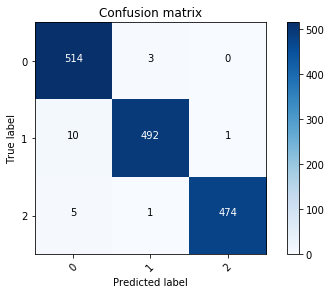

In [95]:
cm = confusion_matrix(y_pred, y_valid)
plot_confusion(cm,[0,1,2])

## Accuracies

In [48]:
print(classification_report(y_valid, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       529
          1       0.98      0.99      0.98       496
          2       0.99      1.00      0.99       475

avg / total       0.99      0.99      0.99      1500

